# Customer Churn Prediction | Class Balancing | Recall - Precision Tradeoff 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn/Customer-Churn-Records.csv


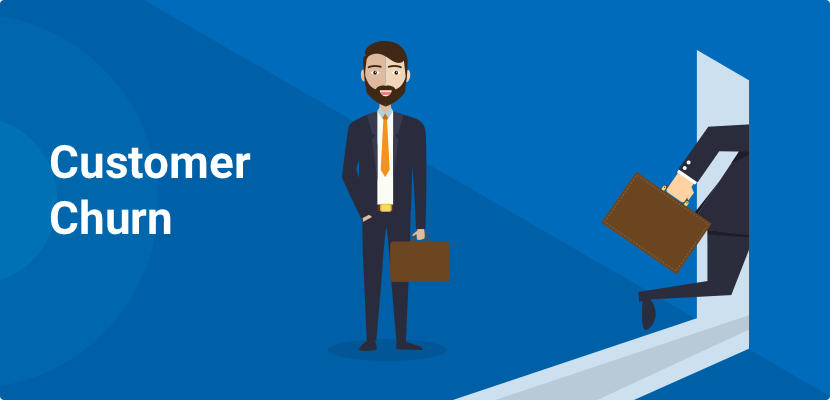
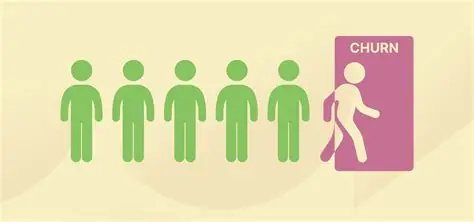
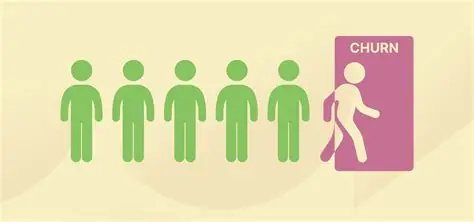
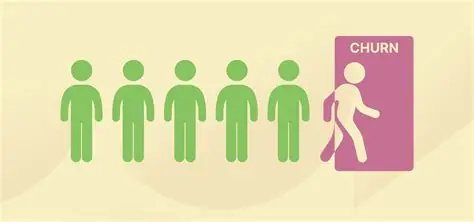
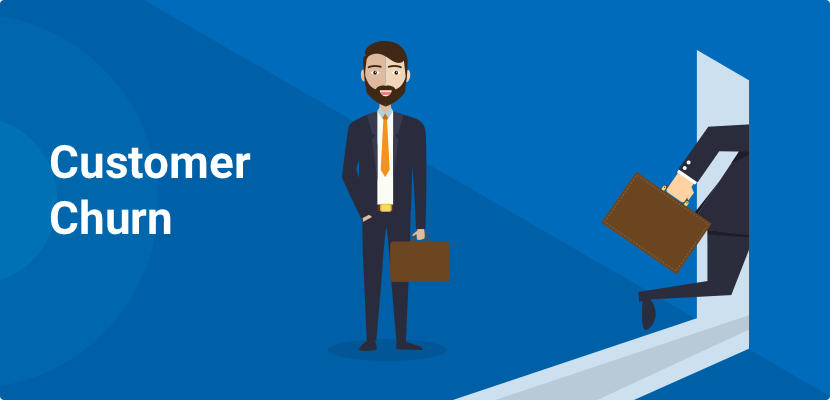
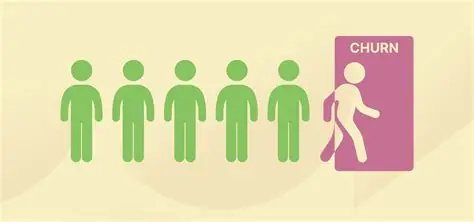

Customer churn — when customers stop using a company’s services — is a major concern in the banking sector, as acquiring new customers is often more costly than retaining existing ones. This project focuses on analyzing and predicting customer churn for a bank using historical data. Our goal is to identify patterns that indicate whether a customer is likely to leave, allowing the bank to take proactive retention measures. The analysis covers data exploration, handling class imbalance, model building, and performance comparison, with a particular focus on achieving strong recall (catching as many churners as possible) without sacrificing overall model reliability.

# Data Loading & Preprocessing

In [2]:
raw_df = pd.read_csv("/kaggle/input/bank-customer-churn/Customer-Churn-Records.csv")

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [4]:
raw_df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Card Type', 'Point Earned'],
      dtype='object')

In [5]:
raw_df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
2544,2545,15709487,Freeman,668,Germany,Male,34,5,80242.37,2,0,0,56780.97,0,0,3,GOLD,872
7548,7549,15658504,Chiawuotu,584,Germany,Female,62,9,137727.34,2,0,1,121102.90,0,0,5,DIAMOND,581
8831,8832,15645593,Trevisani,599,France,Female,41,2,91328.71,1,1,0,115724.78,0,0,1,GOLD,381
4626,4627,15622321,Golubova,506,France,Female,32,3,0.00,1,1,1,80823.02,0,0,3,PLATINUM,619
6109,6110,15710105,Stirling,581,Germany,Female,26,3,105099.45,1,1,1,184520.00,1,1,5,DIAMOND,877


In [6]:
# Check for missing/null values
print("\nMissing Values:\n", raw_df.isnull().sum())

# Check for duplicated rows
print("\nDuplicated Rows:", raw_df.duplicated().sum())

# Basic stats for numerical columns
print("\nDescriptive Stats:\n", raw_df.describe())

# Basic stats for cat columns
print("\nDescriptive Stats Cat:\n", raw_df.describe(include='object'))


Missing Values:
 RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

Duplicated Rows: 0

Descriptive Stats:
          RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074

In [7]:
# Drop irrelevant columns and create a new version
df = raw_df.drop(columns=['RowNumber', 'Surname'])

# Confirm new shape
print(f"New shape: {df.shape}")


New shape: (10000, 16)


In [8]:
# Primary Key
primary_key = ['CustomerId']

# Target Variable
target_col = ['Exited']

# Binary Categorical Columns (0 or 1)
bin_col = ['HasCrCard', 'IsActiveMember', 'Complain']

# Nominal/Ordinal Categorical Columns
cat_col = ['Geography', 'Gender', 'Card Type']

# Numerical Columns (continuous)
cont_col = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Point Earned'] #kept age as continuos since the range is quite wide

# Numerical Columns (continuous)
disc_col = ['Tenure', 'NumOfProducts', 'Satisfaction Score']

In [9]:
print("Primary Key:", primary_key)
print("Target Column:", target_col)
print("Binary Columns:", bin_col)
print("Categorical Columns:", cat_col)
print("Continuous Columns:", cont_col)
print("Discrete Columns:", disc_col)

Primary Key: ['CustomerId']
Target Column: ['Exited']
Binary Columns: ['HasCrCard', 'IsActiveMember', 'Complain']
Categorical Columns: ['Geography', 'Gender', 'Card Type']
Continuous Columns: ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Point Earned']
Discrete Columns: ['Tenure', 'NumOfProducts', 'Satisfaction Score']


In [10]:
# Check for duplicates in CustomerId
duplicate_count = df['CustomerId'].duplicated().sum()
print(f"Number of duplicate Customer IDs: {duplicate_count}")

Number of duplicate Customer IDs: 0


# EDA

## Univariate

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


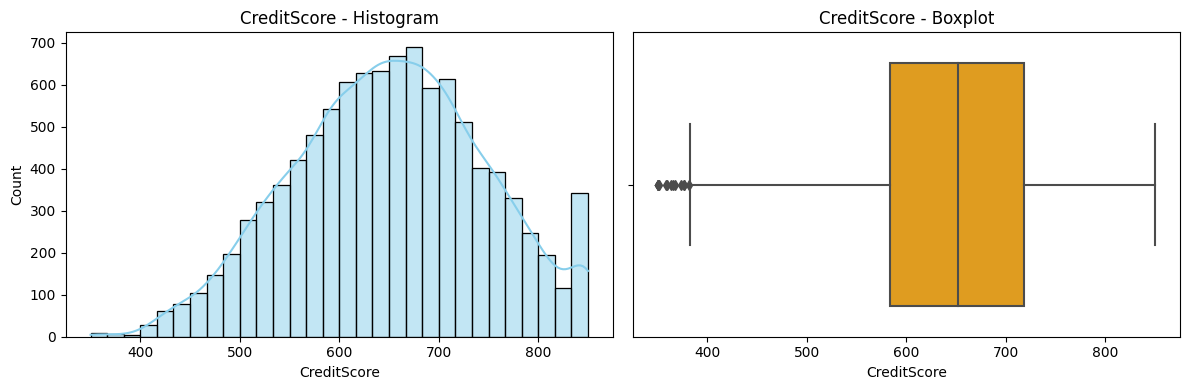

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


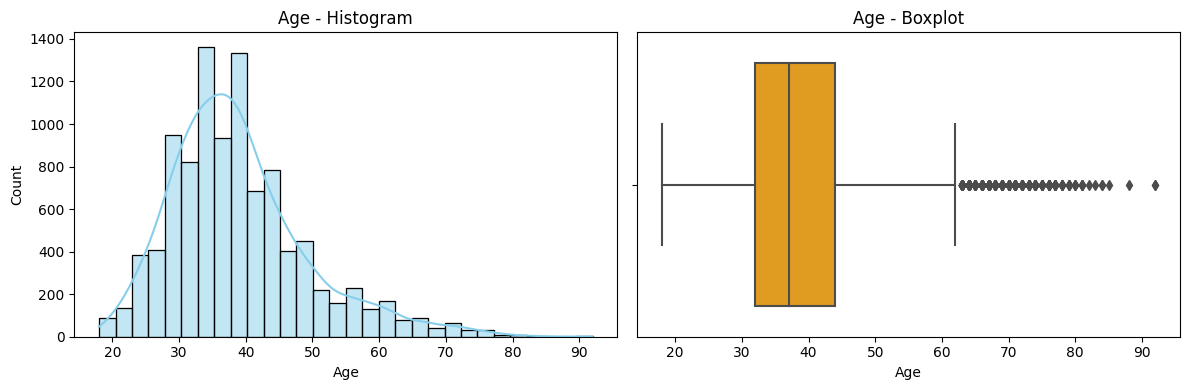

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


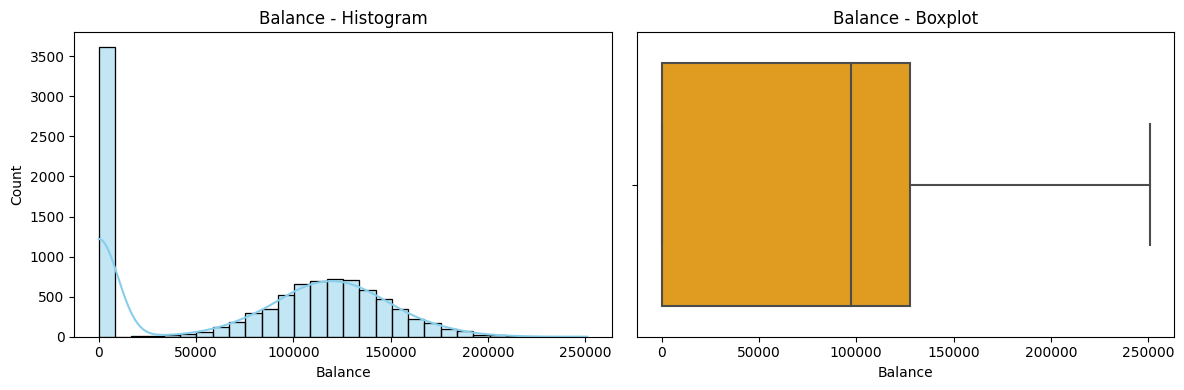

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


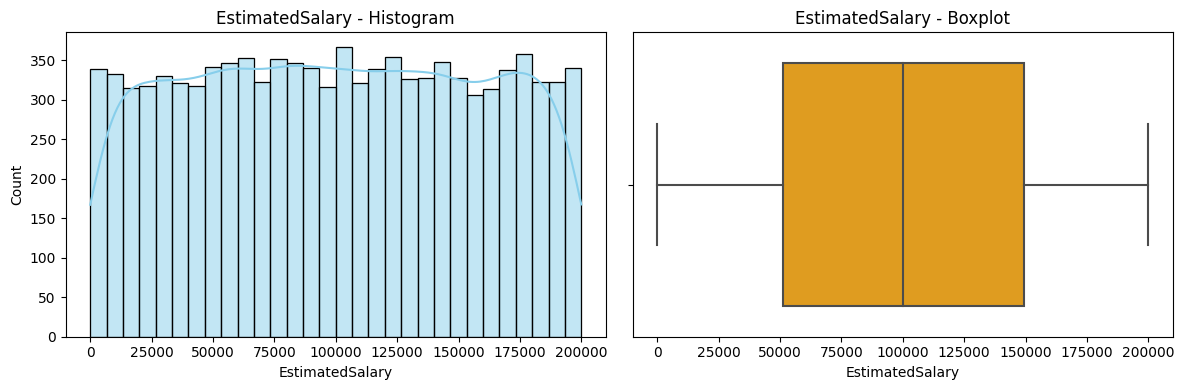

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


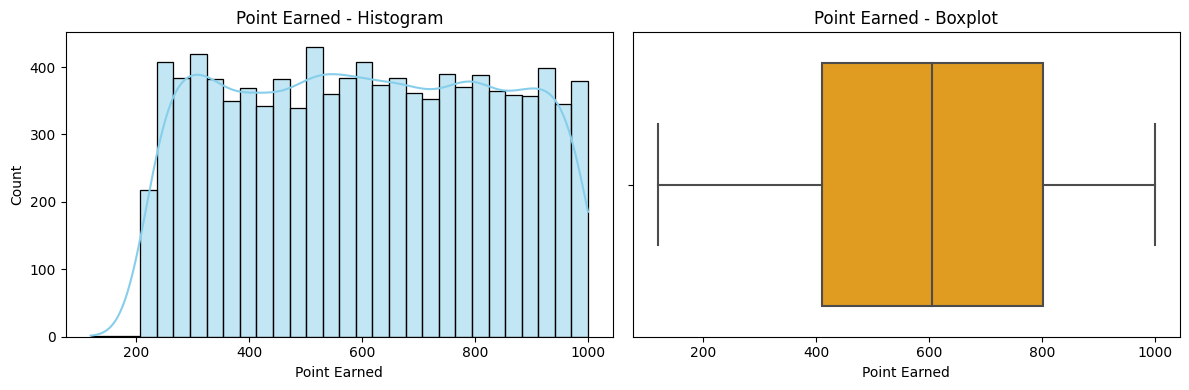

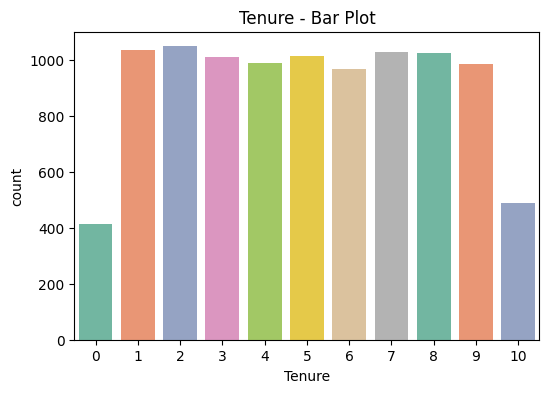

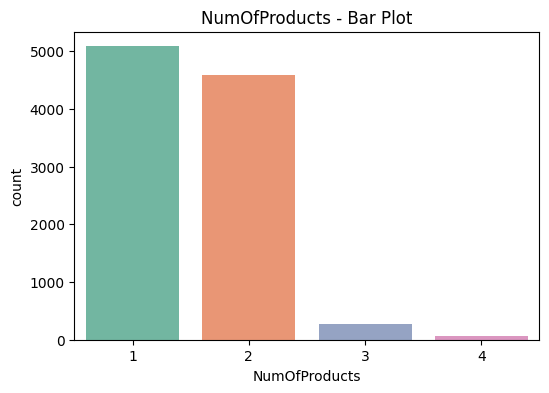

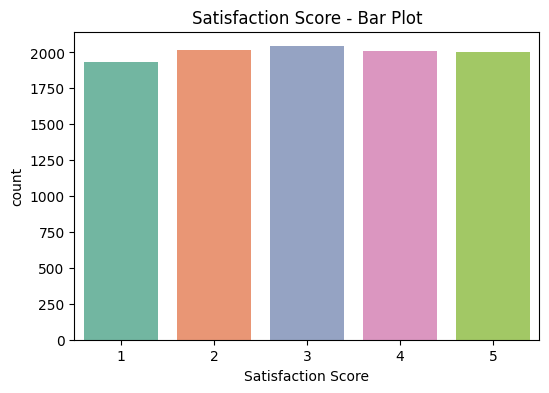

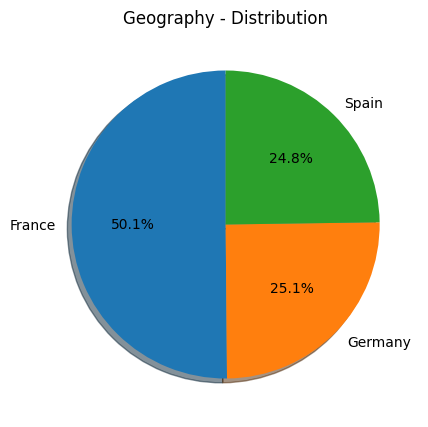

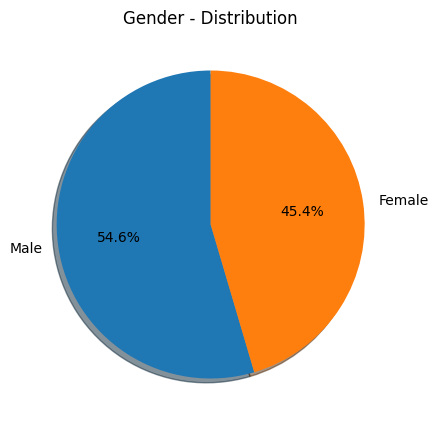

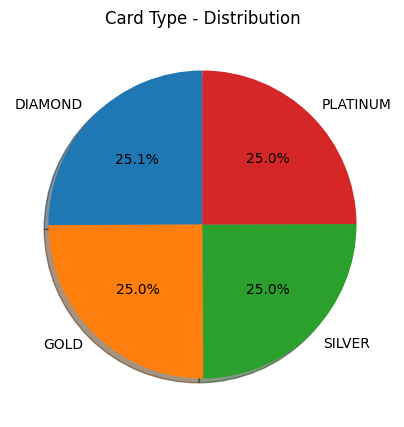

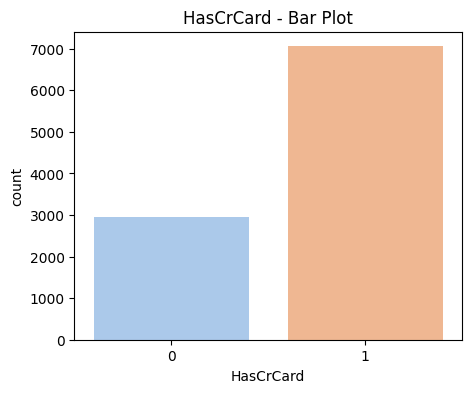

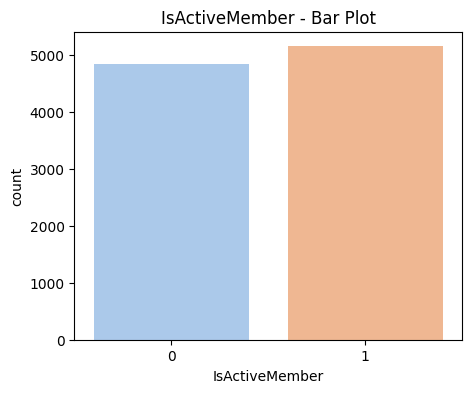

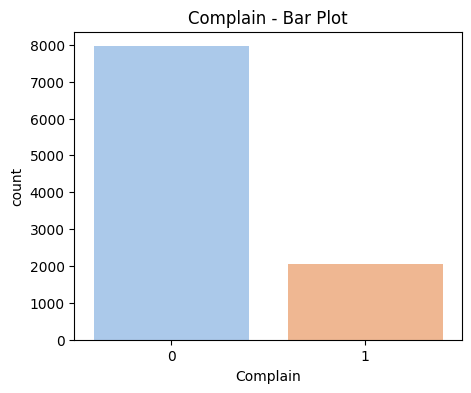

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Continuous Columns
for col in cont_col:
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'{col} - Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='orange')
    plt.title(f'{col} - Boxplot')

    plt.tight_layout()
    plt.show()

# Plot Discrete Columns
for col in disc_col:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, palette='Set2')
    plt.title(f'{col} - Bar Plot')
    plt.xticks(rotation=0)
    plt.show()

# Plot Categorical Columns as Pie Charts
for col in cat_col:
    plt.figure(figsize=(5, 5))
    df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title(f'{col} - Distribution')
    plt.ylabel('')
    plt.show()

# Plot Binary Columns as Bar Plots
for col in bin_col:
    plt.figure(figsize=(5, 4))
    sns.countplot(data=df, x=col, palette='pastel')
    plt.title(f'{col} - Bar Plot')
    plt.xticks(rotation=0)
    plt.show()


**Target**

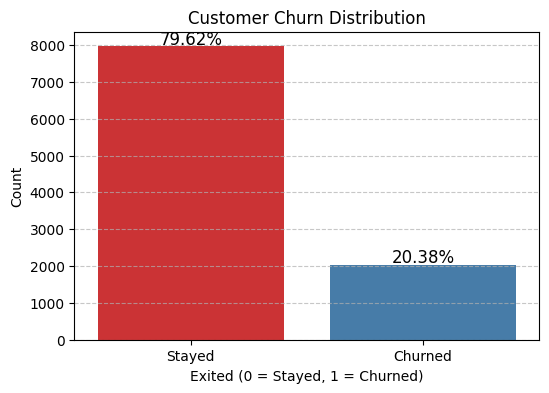

In [12]:
# Countplot for churn (Exited)
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Exited', palette='Set1')

# Annotate percentages
total = len(df)
for p in plt.gca().patches:
    height = p.get_height()
    percent = f'{100 * height / total:.2f}%'
    plt.gca().text(p.get_x() + p.get_width()/2., height + 50, percent, ha='center', fontsize=12)

plt.title("Customer Churn Distribution")
plt.xlabel("Exited (0 = Stayed, 1 = Churned)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Stayed', 'Churned'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Bivariate

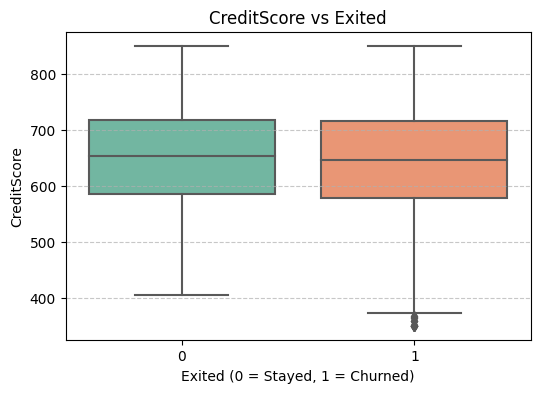

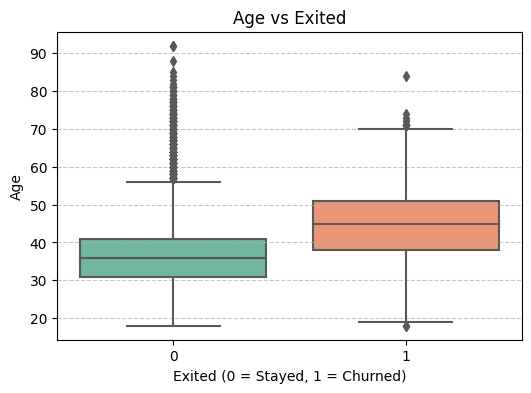

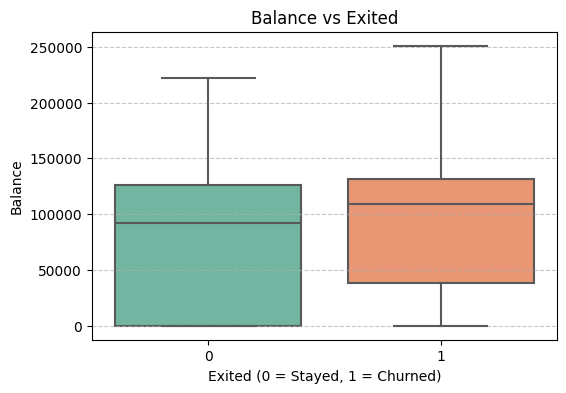

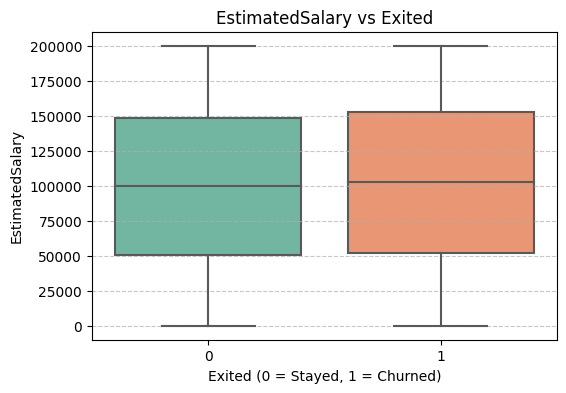

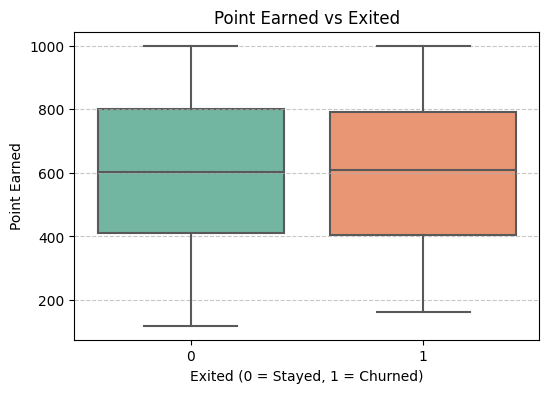

In [13]:
for col in cont_col:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Exited', y=col, data=df, palette='Set2')
    plt.title(f'{col} vs Exited')
    plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

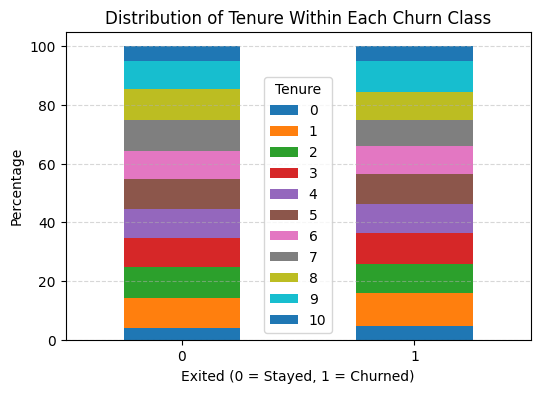

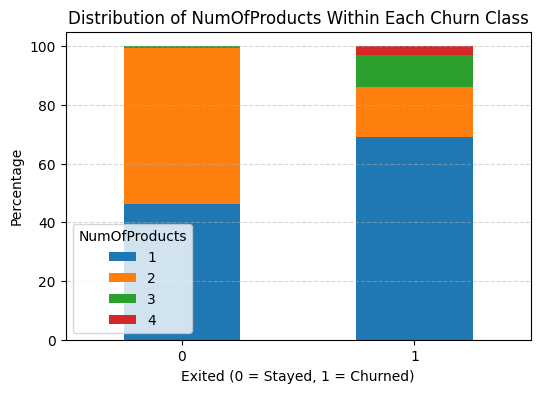

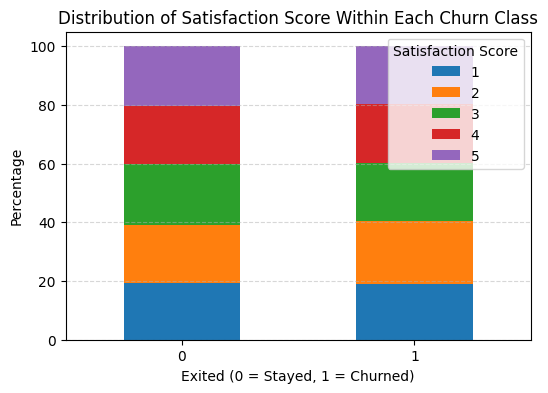

In [14]:
for col in disc_col:
    prop_df = df.groupby('Exited')[col].value_counts(normalize=True).unstack().fillna(0) * 100
    prop_df.plot(kind='bar', stacked=True, figsize=(6, 4))
    plt.title(f'Distribution of {col} Within Each Churn Class')
    plt.ylabel('Percentage')
    plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
    plt.legend(title=col)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

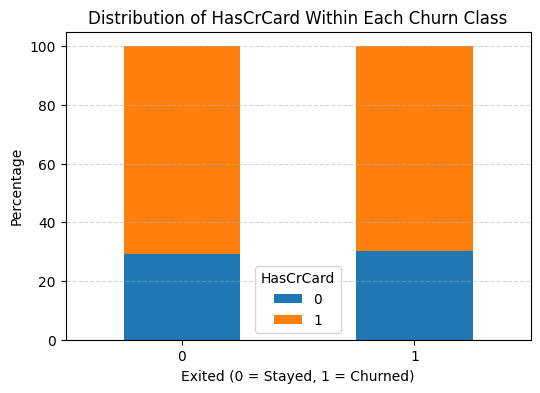

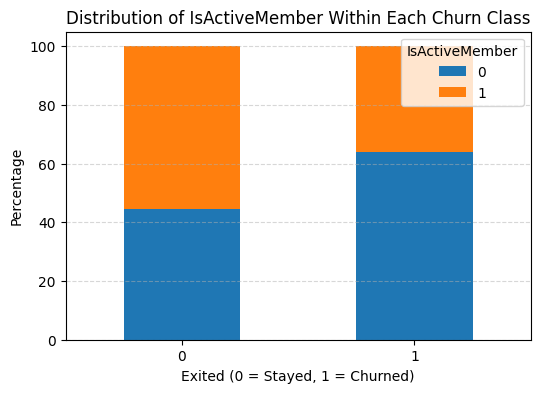

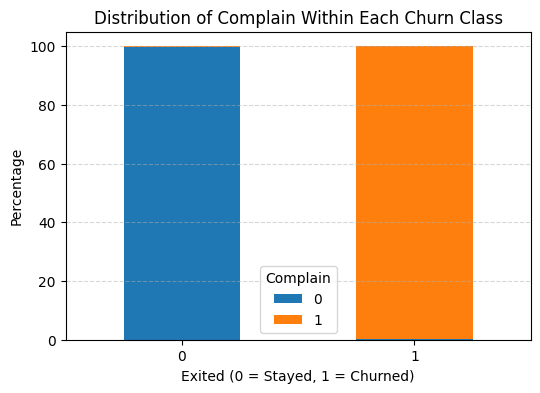

In [15]:
for col in bin_col:
    prop_df = df.groupby('Exited')[col].value_counts(normalize=True).unstack().fillna(0) * 100
    prop_df.plot(kind='bar', stacked=True, figsize=(6, 4))
    plt.title(f'Distribution of {col} Within Each Churn Class')
    plt.ylabel('Percentage')
    plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
    plt.legend(title=col)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

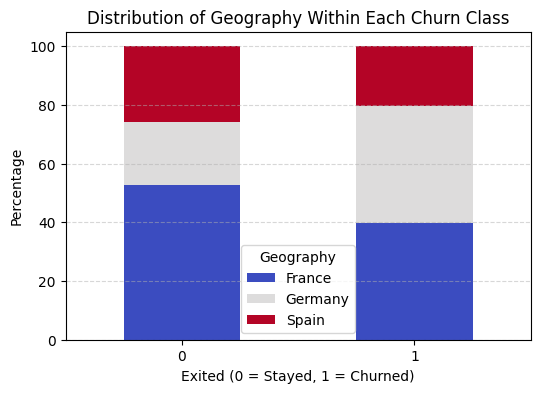

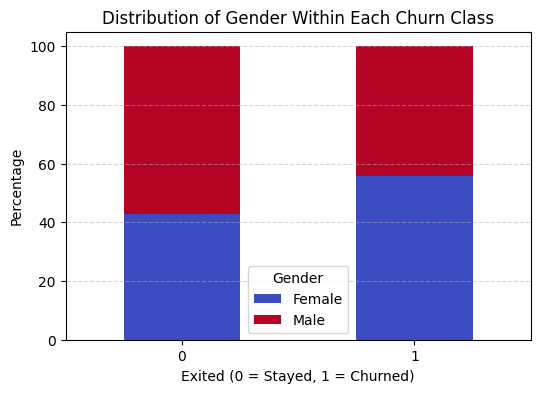

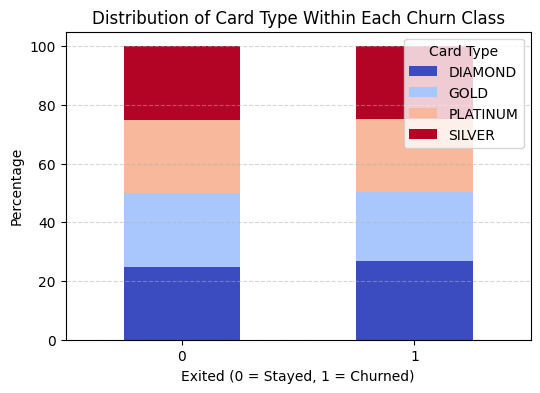

In [16]:
for col in cat_col:
    prop_df = df.groupby('Exited')[col].value_counts(normalize=True).unstack().fillna(0) * 100
    prop_df.plot(kind='bar', stacked=True, figsize=(6, 4), colormap='coolwarm')
    plt.title(f'Distribution of {col} Within Each Churn Class')
    plt.ylabel('Percentage')
    plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
    plt.legend(title=col)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

**Correlation**

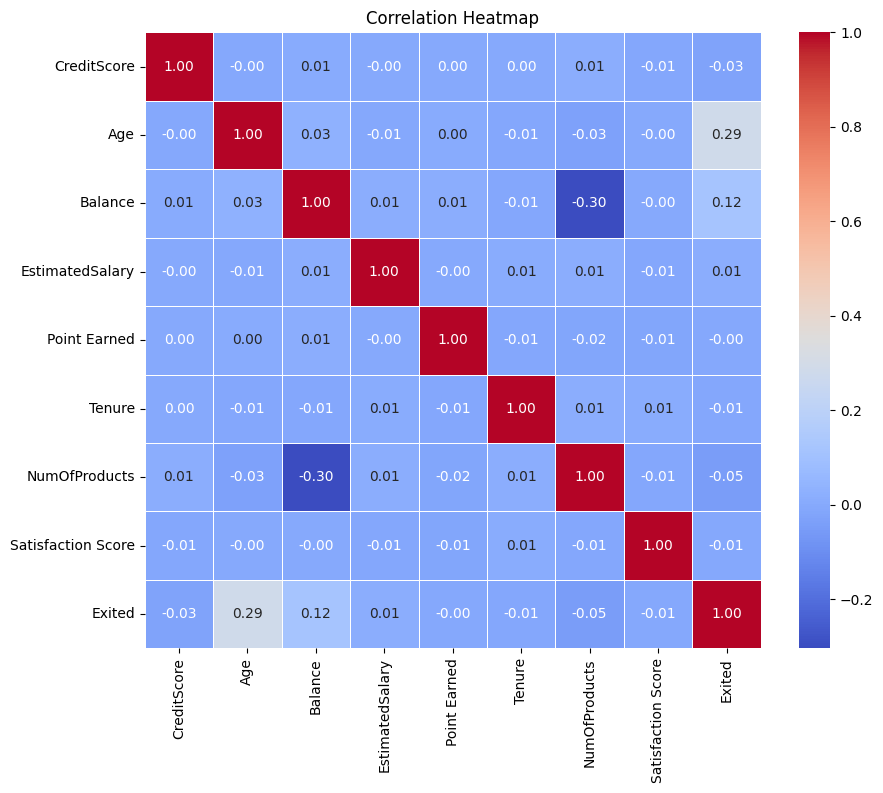

In [17]:
# Create correlation matrix
corr_matrix = df[cont_col + disc_col + target_col].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


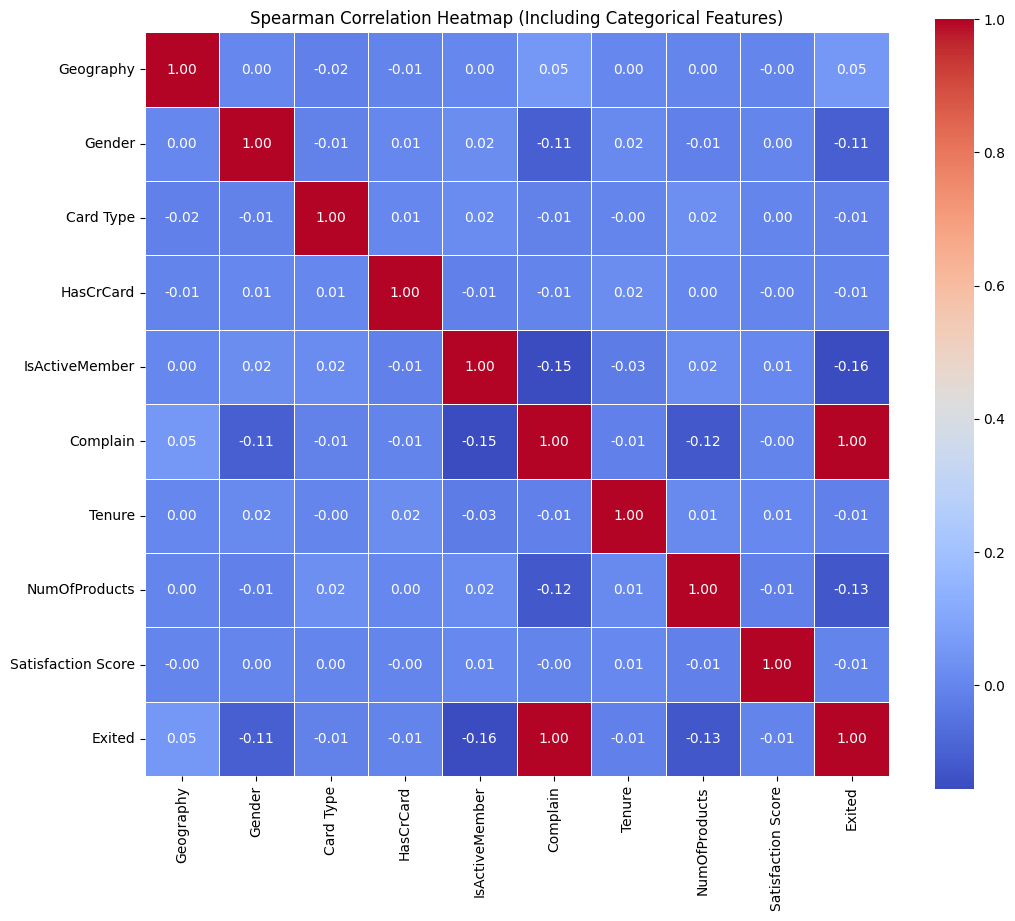

In [18]:
# Make a temporary copy
df_encoded = df.copy()

# Encode categorical, binary, and discrete columns as numeric for correlation
from sklearn.preprocessing import LabelEncoder

for col in cat_col + bin_col + disc_col:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Compute Spearman correlation
spearman_corr = df_encoded[cat_col + bin_col + disc_col + target_col].corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("Spearman Correlation Heatmap (Including Categorical Features)")
plt.show()


In [19]:
pd.crosstab(df['Complain'], df['Exited'], normalize='index') * 100

Exited,0,1
Complain,,
0,99.949723,0.050277
1,0.489237,99.510763


**Dropping Complain**

Reason for Dropping Complain:


The Complain feature shows an almost perfect correlation with the target variable Exited (~99.5% of customers who complained have churned). This suggests that the complaint information may have been recorded at or after the churn event, causing data leakage. Including this feature would allow the model to trivially predict churn, leading to overly optimistic and unrealistic performance. To build a reliable and generalizable churn prediction model, we therefore remove Complain from the dataset.

In [20]:
# Drop 'Complain' and 'CustomerId' columns
df_v2 = df.drop(columns=['Complain', 'CustomerId']).copy()

# Update binary columns list accordingly
bin_col.remove('Complain')


In [21]:
# 1. Check for missing values again
print("Missing values:\n", df_v2.isnull().sum())

# 2. Unique counts for categorical and binary columns
for col in cat_col + bin_col:
    print(f"\nUnique values in {col}: {df_v2[col].unique()}")

# 3. Data types check
print("\nData types:\n", df_v2.dtypes)


Missing values:
 CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

Unique values in Geography: ['France' 'Spain' 'Germany']

Unique values in Gender: ['Female' 'Male']

Unique values in Card Type: ['DIAMOND' 'GOLD' 'SILVER' 'PLATINUM']

Unique values in HasCrCard: [1 0]

Unique values in IsActiveMember: [1 0]

Data types:
 CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Satisfaction Score      int64
Card Type      

# Model Building

## Baseline Models with Class imbalance

In [22]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define columns again for clarity
cat_cols = cat_col  # ['Geography', 'Gender', 'Card Type']
bin_cols = bin_col  # binary columns already 0/1, no encoding needed
cont_cols = cont_col  # continuous numerical columns for scaling
disc_cols = disc_col  # discrete numerical columns, leave as is

# Preprocessor setup
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', sparse=False), cat_cols),  # drop first to avoid dummy trap
        ('scaler', StandardScaler(), cont_cols)
    ],
    remainder='passthrough'  # pass binary and discrete columns unchanged
)

# Fit and transform the whole dataset (excluding target)
X = df_v2.drop(columns=target_col)
y = df_v2[target_col].values.ravel()

X_processed = preprocessor.fit_transform(X)

# To get feature names after one-hot encoding for reference
ohe_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
final_feature_names = list(ohe_feature_names) + cont_cols + bin_cols + disc_cols

print(f"Processed data shape: {X_processed.shape}")
print(f"Features after encoding and scaling: {final_feature_names}")


Processed data shape: (10000, 16)
Features after encoding and scaling: ['Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Point Earned', 'HasCrCard', 'IsActiveMember', 'Tenure', 'NumOfProducts', 'Satisfaction Score']


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Applied encoding and scaling using a ColumnTransformer pipeline to ensure that categorical and continuous features were properly handled. This preprocessor will be saved and used during deployment to maintain consistency between training and inference data.



In [23]:
from sklearn.model_selection import train_test_split

# 80-20 split, stratify on target to maintain imbalance ratio
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (8000, 16), Test shape: (2000, 16)


**Basline Models before handling class imbalance**

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix\nAccuracy: {acc:.2f}, F1: {f1:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC curve plot if possible
    if y_proba is not None:
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0,1], [0,1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()
    
    # Metrics summary table
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
        'Score': [acc, prec, rec, f1, roc_auc]
    })
    display(metrics_df.style.format({'Score': '{:.4f}'}))
    
    # Return metrics as dict for easy comparison
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "roc_auc": roc_auc
    }


### Logistic Regression

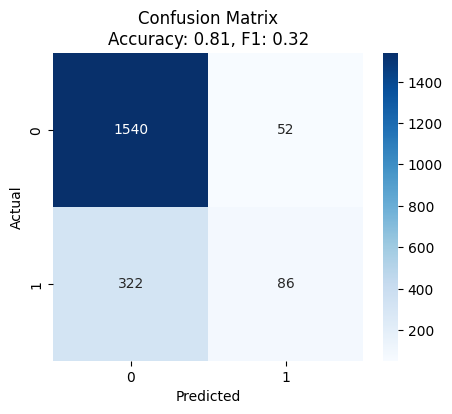

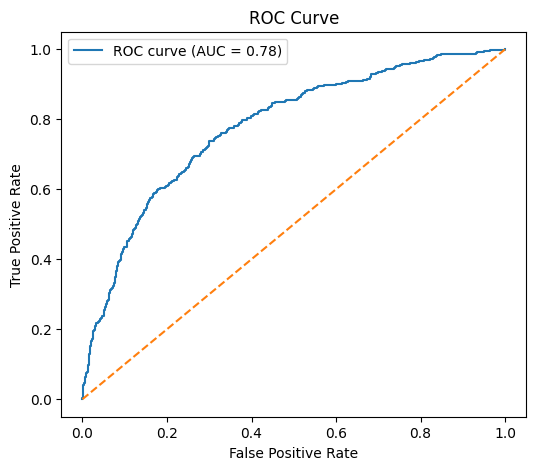

,Metric,Score
0,Accuracy,0.8130
1,Precision,0.6232
2,Recall,0.2108
3,F1 Score,0.3150
4,ROC AUC,0.7784


Baseline Logistic Regression Metrics: {'accuracy': 0.813, 'precision': 0.6231884057971014, 'recall': 0.2107843137254902, 'f1_score': 0.315018315018315, 'roc_auc': 0.7784218272736231}


In [25]:
from sklearn.linear_model import LogisticRegression

baseline_model = LogisticRegression(random_state=42, max_iter=500)
metrics = train_evaluate_model(baseline_model, X_train, y_train, X_test, y_test)
print("Baseline Logistic Regression Metrics:", metrics)


### Random Forest

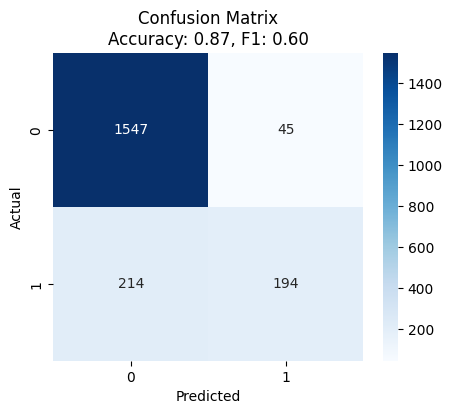

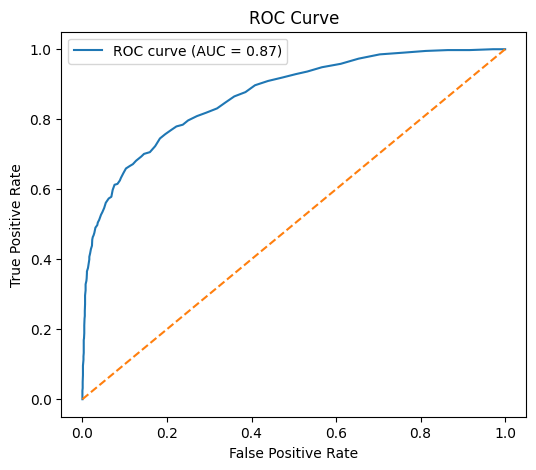

,Metric,Score
0,Accuracy,0.8705
1,Precision,0.8117
2,Recall,0.4755
3,F1 Score,0.5997
4,ROC AUC,0.8673


Random Forest Metrics: {'accuracy': 0.8705, 'precision': 0.8117154811715481, 'recall': 0.47549019607843135, 'f1_score': 0.5996908809891809, 'roc_auc': 0.8673383769336881}


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
metrics_rf = train_evaluate_model(rf_model, X_train, y_train, X_test, y_test)
print("Random Forest Metrics:", metrics_rf)

### XGB

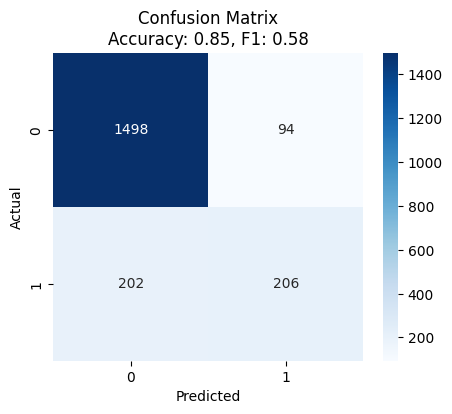

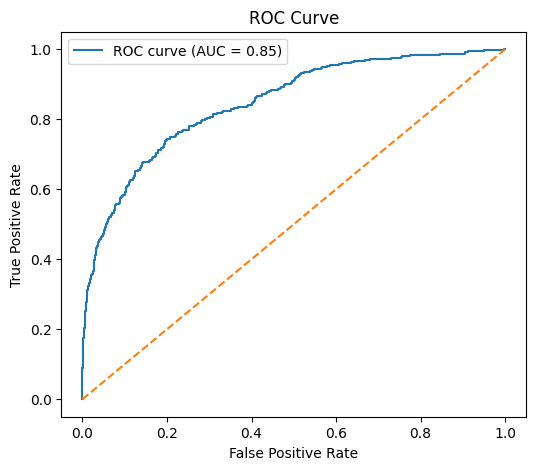

,Metric,Score
0,Accuracy,0.8520
1,Precision,0.6867
2,Recall,0.5049
3,F1 Score,0.5819
4,ROC AUC,0.8464


XGBoost Metrics: {'accuracy': 0.852, 'precision': 0.6866666666666666, 'recall': 0.5049019607843137, 'f1_score': 0.5819209039548023, 'roc_auc': 0.846427295792689}


In [27]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    verbosity=0
)

metrics_xgb = train_evaluate_model(xgb_model, X_train, y_train, X_test, y_test)
print("XGBoost Metrics:", metrics_xgb)


Considering the dataset had approximately 20% churners and 80% non-churners,  explored various methods to address imbalance, including manual oversampling and class weights. This ensured our models had a fair chance at learning patterns related to the minority class (churners) without being biased toward the majority class.

## Models - Class Imbalance Handling

### RF with Class weight

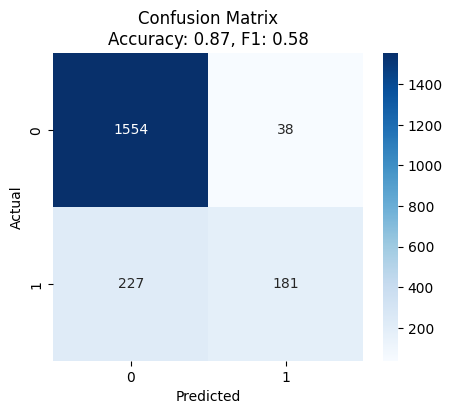

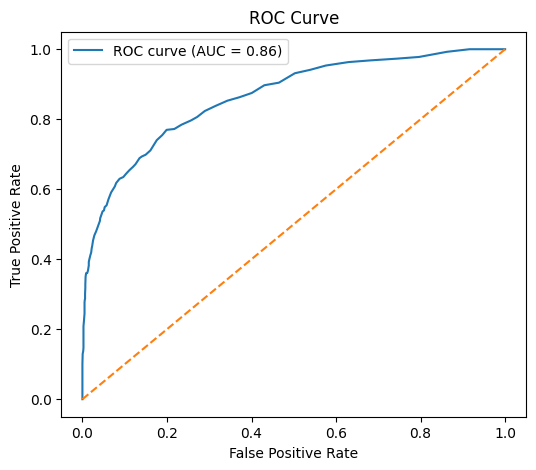

,Metric,Score
0,Accuracy,0.8675
1,Precision,0.8265
2,Recall,0.4436
3,F1 Score,0.5774
4,ROC AUC,0.8637


Random Forest with Class Weights Metrics: {'accuracy': 0.8675, 'precision': 0.8264840182648402, 'recall': 0.44362745098039214, 'f1_score': 0.5773524720893141, 'roc_auc': 0.8636649854665485}


In [28]:
rf_weighted = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
metrics_rf_wt = train_evaluate_model(rf_weighted, X_train, y_train, X_test, y_test)
print("Random Forest with Class Weights Metrics:", metrics_rf_wt)

### XGB with Class weights

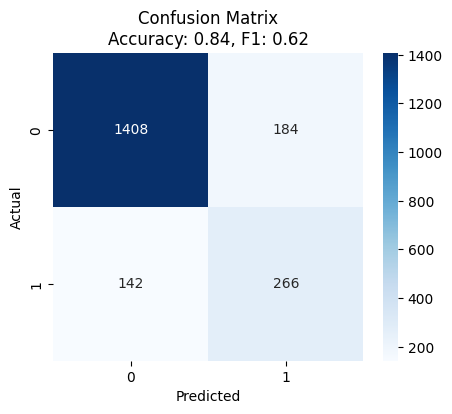

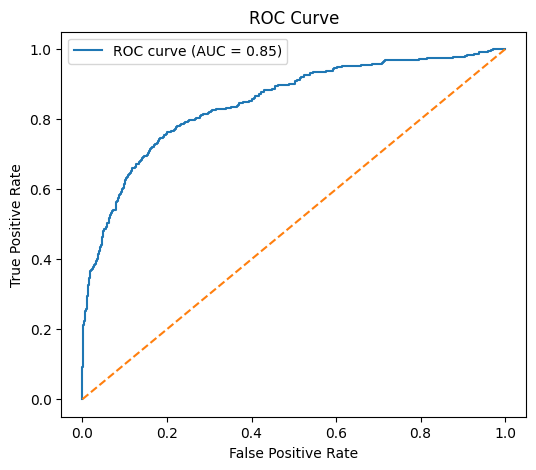

,Metric,Score
0,Accuracy,0.8370
1,Precision,0.5911
2,Recall,0.6520
3,F1 Score,0.6200
4,ROC AUC,0.8477


XGBoost with Class Weights Metrics: {'accuracy': 0.837, 'precision': 0.5911111111111111, 'recall': 0.6519607843137255, 'f1_score': 0.6200466200466201, 'roc_auc': 0.8477066706079417}


In [29]:
# Calculate scale_pos_weight
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = neg / pos

xgb_weighted = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    verbosity=0
)
metrics_xgb_wt = train_evaluate_model(xgb_weighted, X_train, y_train, X_test, y_test)
print("XGBoost with Class Weights Metrics:", metrics_xgb_wt)

### RF with oversampling

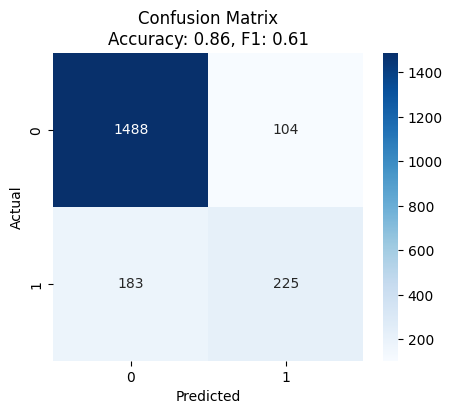

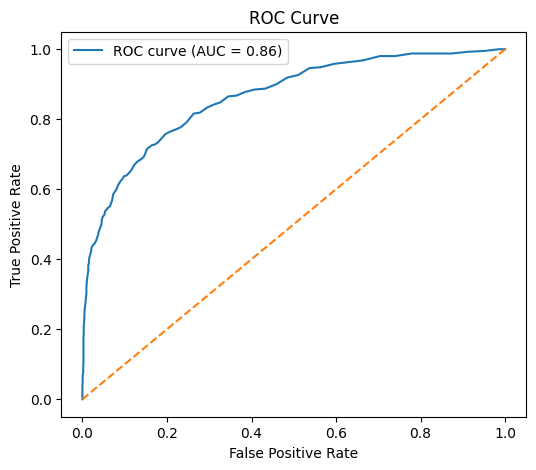

,Metric,Score
0,Accuracy,0.8565
1,Precision,0.6839
2,Recall,0.5515
3,F1 Score,0.6106
4,ROC AUC,0.8631


Random Forest with Manual Oversampling Metrics: {'accuracy': 0.8565, 'precision': 0.6838905775075987, 'recall': 0.5514705882352942, 'f1_score': 0.6105834464043419, 'roc_auc': 0.8630699453148093}


In [30]:


# Find positive class rows
X_train_pos = X_train[y_train == 1]
y_train_pos = y_train[y_train == 1]

# Oversample by duplicating positive class until balance
n_needed = (y_train == 0).sum() - (y_train == 1).sum()
n_repeats = n_needed // len(y_train_pos) + 1

X_pos_oversampled = np.tile(X_train_pos, (n_repeats, 1))[:n_needed]
y_pos_oversampled = np.ones(n_needed)

# Combine with original train data
X_train_over = np.vstack([X_train, X_pos_oversampled])
y_train_over = np.concatenate([y_train, y_pos_oversampled])

# Shuffle
from sklearn.utils import shuffle
X_train_over, y_train_over = shuffle(X_train_over, y_train_over, random_state=42)

# Train model
rf_over = RandomForestClassifier(random_state=42, n_estimators=100)
metrics_rf_over = train_evaluate_model(rf_over, X_train_over, y_train_over, X_test, y_test)
print("Random Forest with Manual Oversampling Metrics:", metrics_rf_over)


### XGB with oversampling

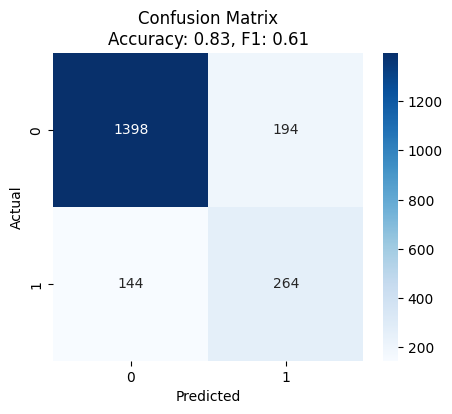

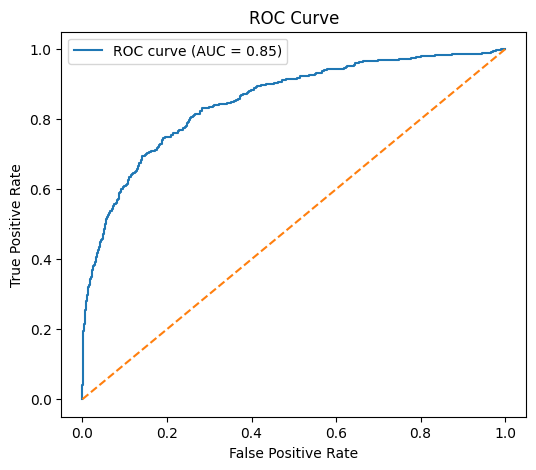

,Metric,Score
0,Accuracy,0.8310
1,Precision,0.5764
2,Recall,0.6471
3,F1 Score,0.6097
4,ROC AUC,0.8521


XGBoost with Manual Oversampling Metrics: {'accuracy': 0.831, 'precision': 0.5764192139737991, 'recall': 0.6470588235294118, 'f1_score': 0.609699769053118, 'roc_auc': 0.8520774830032516}


In [31]:
# XGBoost on manually oversampled data
xgb_over = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    verbosity=0
)

metrics_xgb_over = train_evaluate_model(xgb_over, X_train_over, y_train_over, X_test, y_test)
print("XGBoost with Manual Oversampling Metrics:", metrics_xgb_over)


### SVM with oversampling

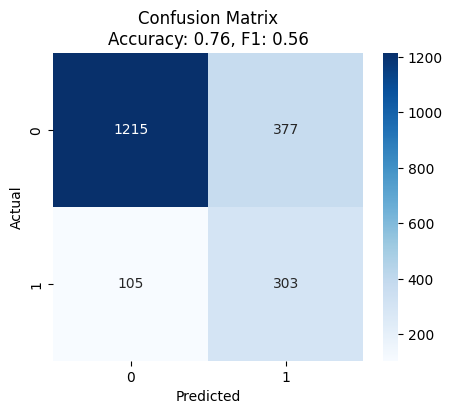

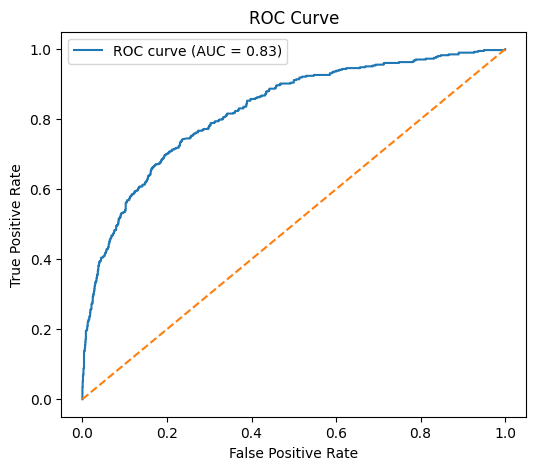

,Metric,Score
0,Accuracy,0.7590
1,Precision,0.4456
2,Recall,0.7426
3,F1 Score,0.5570
4,ROC AUC,0.8260


SVM with Manual Oversampling Metrics: {'accuracy': 0.759, 'precision': 0.4455882352941177, 'recall': 0.7426470588235294, 'f1_score': 0.5569852941176471, 'roc_auc': 0.825987320179328}


In [32]:
from sklearn.svm import SVC

# SVM setup — probability=True to enable ROC AUC
svm_model = SVC(probability=True, random_state=42)

# Train + evaluate using your reusable function
metrics_svm_over = train_evaluate_model(svm_model, X_train_over, y_train_over, X_test, y_test)

print("SVM with Manual Oversampling Metrics:", metrics_svm_over)

## Feature Importance

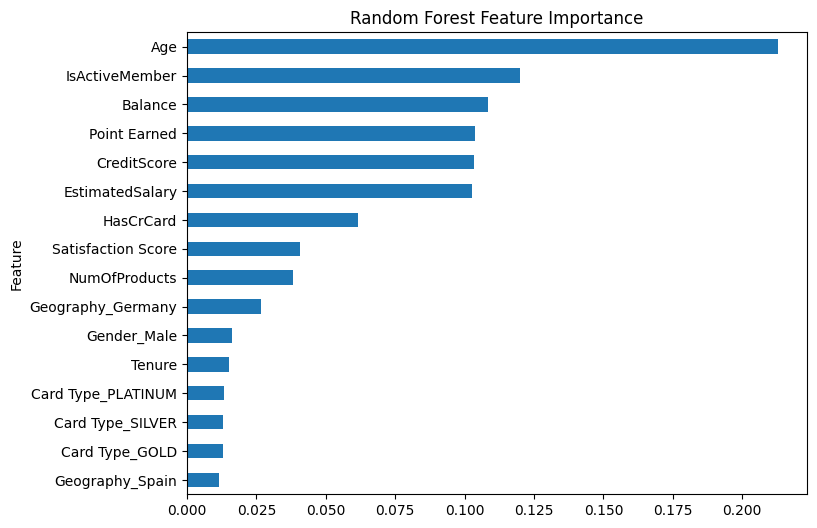

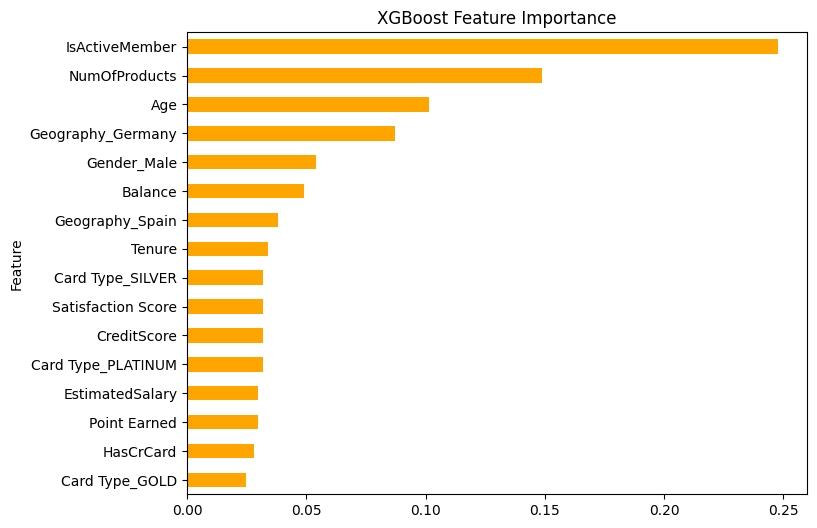

In [33]:
importances_rf = rf_model.feature_importances_
importances_xgb = xgb_model.feature_importances_

# Random Forest feature importance
feat_imp_rf = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

feat_imp_rf.set_index('Feature').plot(kind='barh', figsize=(8,6), legend=False)
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# XGBoost feature importance
feat_imp_xgb = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

feat_imp_xgb.set_index('Feature').plot(kind='barh', figsize=(8,6), color='orange', legend=False)
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()


### RF & XGB with Reduced metrics

Selected 11 features:
['Geography_Germany', 'Gender_Male', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Point Earned', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Satisfaction Score']


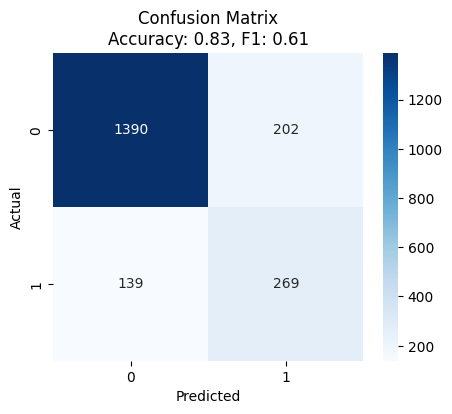

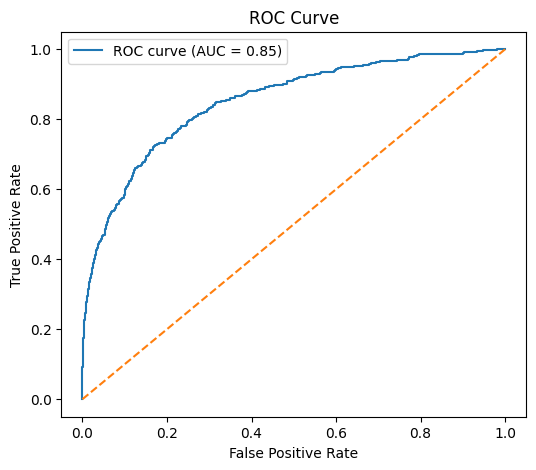

,Metric,Score
0,Accuracy,0.8295
1,Precision,0.5711
2,Recall,0.6593
3,F1 Score,0.6121
4,ROC AUC,0.8508


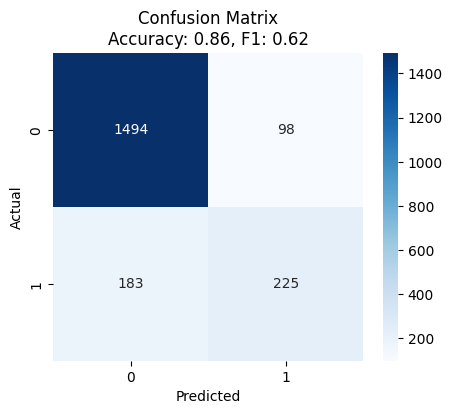

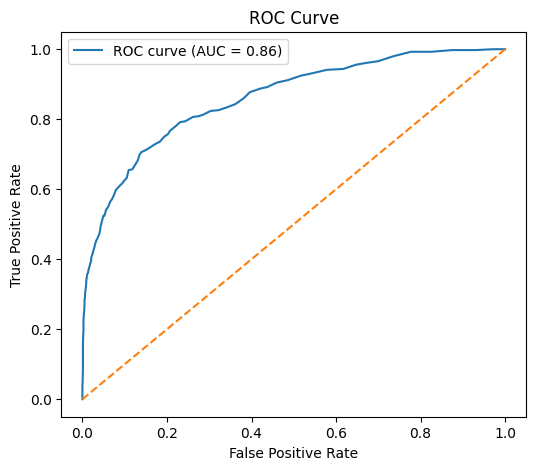

,Metric,Score
0,Accuracy,0.8595
1,Precision,0.6966
2,Recall,0.5515
3,F1 Score,0.6156
4,ROC AUC,0.8594


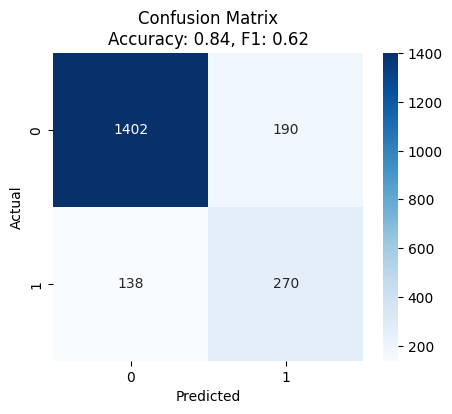

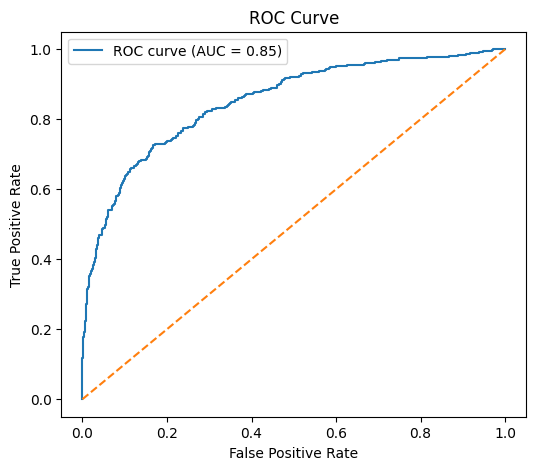

,Metric,Score
0,Accuracy,0.8360
1,Precision,0.5870
2,Recall,0.6618
3,F1 Score,0.6221
4,ROC AUC,0.8510


XGBoost with Class Weights Metrics: {'accuracy': 0.8295, 'precision': 0.5711252653927813, 'recall': 0.6593137254901961, 'f1_score': 0.6120591581342435, 'roc_auc': 0.8508135037934772}
Random Forest with Manual Oversampling Metrics: {'accuracy': 0.8595, 'precision': 0.6965944272445821, 'recall': 0.5514705882352942, 'f1_score': 0.6155950752393982, 'roc_auc': 0.8594258054980786}
XGBoost with Manual Oversampling Metrics: {'accuracy': 0.836, 'precision': 0.5869565217391305, 'recall': 0.6617647058823529, 'f1_score': 0.6221198156682028, 'roc_auc': 0.8509920928170264}


In [34]:


# 1. Merge importance dfs as before
feat_imp_rf = pd.DataFrame({'Feature': final_feature_names, 'Importance_RF': importances_rf})
feat_imp_xgb = pd.DataFrame({'Feature': final_feature_names, 'Importance_XGB': importances_xgb})
feat_imp = pd.merge(feat_imp_rf, feat_imp_xgb, on='Feature')

# 2. Select features > 2% importance in either model
selected_features = feat_imp[
    (feat_imp['Importance_RF'] > 0.025) | (feat_imp['Importance_XGB'] > 0.05)
]['Feature'].tolist()

print(f"Selected {len(selected_features)} features:")
print(selected_features)

# 3. Convert numpy arrays back to DataFrame for column filtering
X_train_df = pd.DataFrame(X_train, columns=final_feature_names)
X_test_df = pd.DataFrame(X_test, columns=final_feature_names)

X_train_reduced = X_train_df[selected_features].values
X_test_reduced = X_test_df[selected_features].values

# 4. Recreate models with proper settings

# XGB with Class Weights
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_class_wt = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight
)

# RF Manual Oversample - assuming you have X_train_over, y_train_over from manual oversampling
rf_manual_over = RandomForestClassifier(random_state=42, n_estimators=100)

# XGB Manual Oversample
xgb_manual_over = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100
)

# 5. Train and evaluate

# XGB Class Weights (no oversampling)
metrics_xgb_class_wt = train_evaluate_model(
    xgb_class_wt,
    X_train_reduced,
    y_train,
    X_test_reduced,
    y_test
)

# RF Manual Oversample (with oversampled data)
X_train_over_df = pd.DataFrame(X_train_over, columns=final_feature_names)
X_train_over_reduced = X_train_over_df[selected_features].values

metrics_rf_manual_over = train_evaluate_model(
    rf_manual_over,
    X_train_over_reduced,
    y_train_over,
    X_test_reduced,
    y_test
)

# XGB Manual Oversample (with oversampled data)
xgb_manual_over = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=100
)

metrics_xgb_manual_over = train_evaluate_model(
    xgb_manual_over,
    X_train_over_reduced,
    y_train_over,
    X_test_reduced,
    y_test
)

# 6. Print results
print("XGBoost with Class Weights Metrics:", metrics_xgb_class_wt)
print("Random Forest with Manual Oversampling Metrics:", metrics_rf_manual_over)
print("XGBoost with Manual Oversampling Metrics:", metrics_xgb_manual_over)


## Results - before Tuning

In [35]:
results = {
    'Logistic Regression': metrics,
    'Random Forest': metrics_rf,
    'XGBoost': metrics_xgb,
    'RF Class Weights': metrics_rf_wt,
    'XGB Class Weights': metrics_xgb_wt,
    'RF Manual Oversample': metrics_rf_over,
    'XGB Manual Oversample' : metrics_xgb_over
}

# After getting metrics from above:

results['XGB Class Weights Reduced'] = metrics_xgb_class_wt
results['RF Manual Oversample Reduced'] = metrics_rf_manual_over
results['XGB Manual Oversample Reduced'] = metrics_xgb_manual_over
results['SVM Manual Oversample'] = metrics_svm_over


results_df = pd.DataFrame(results).T  # Transpose to make models as rows
results_df = results_df.reset_index().rename(columns={'index': 'Model'})
results_df = results_df.round(4)
# display(results_df)


In [36]:
results_df

,Model,accuracy,precision,recall,f1_score,roc_auc
0,Logistic Regression,0.8130,0.6232,0.2108,0.3150,0.7784
1,Random Forest,0.8705,0.8117,0.4755,0.5997,0.8673
2,XGBoost,0.8520,0.6867,0.5049,0.5819,0.8464
3,RF Class Weights,0.8675,0.8265,0.4436,0.5774,0.8637
4,XGB Class Weights,0.8370,0.5911,0.6520,0.6200,0.8477
5,RF Manual Oversample,0.8565,0.6839,0.5515,0.6106,0.8631
6,XGB Manual Oversample,0.8310,0.5764,0.6471,0.6097,0.8521
7,XGB Class Weights Reduced,0.8295,0.5711,0.6593,0.6121,0.8508
8,RF Manual Oversample Reduced,0.8595,0.6966,0.5515,0.6156,0.8594
9,XGB Manual Oversample Reduced,0.8360,0.5870,0.6618,0.6221,0.8510


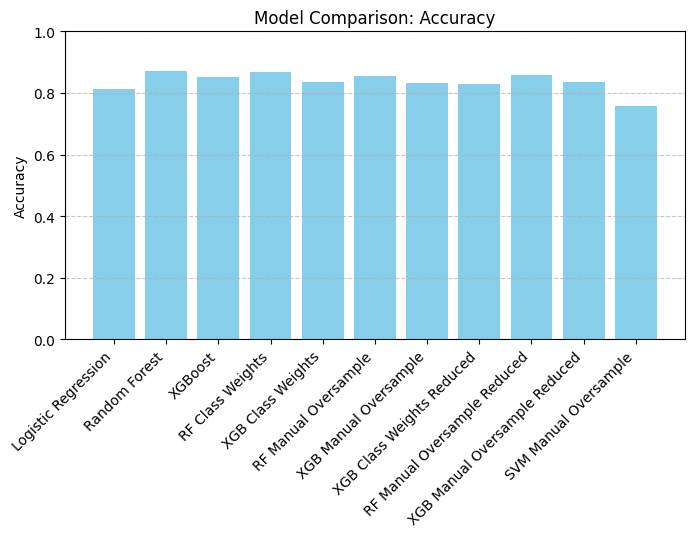

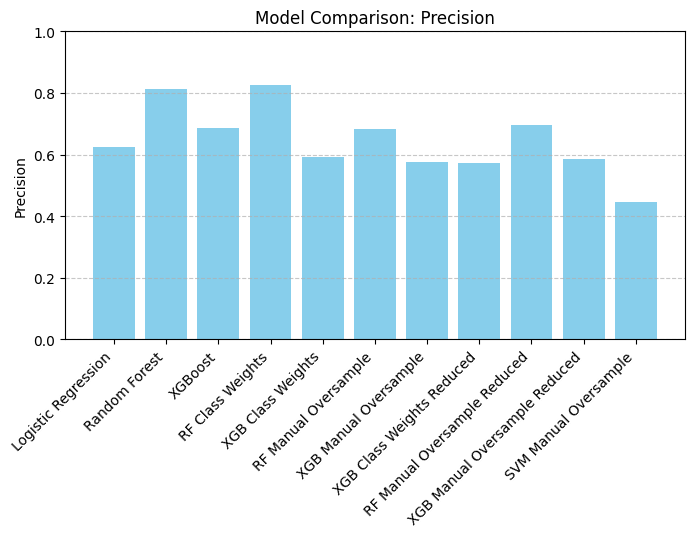

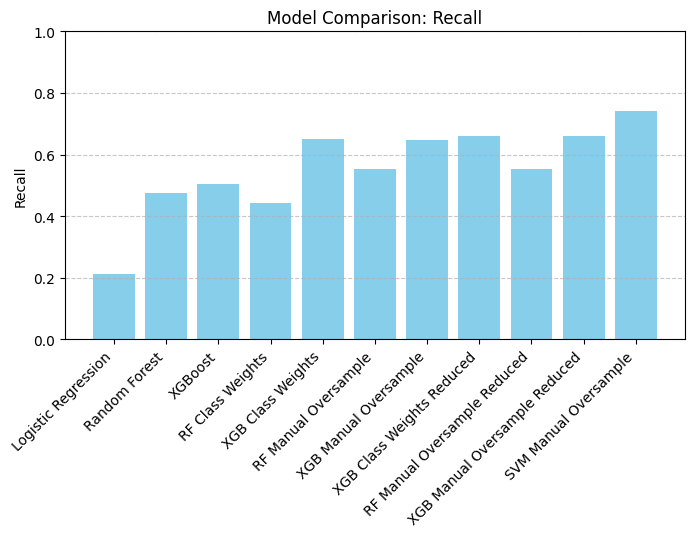

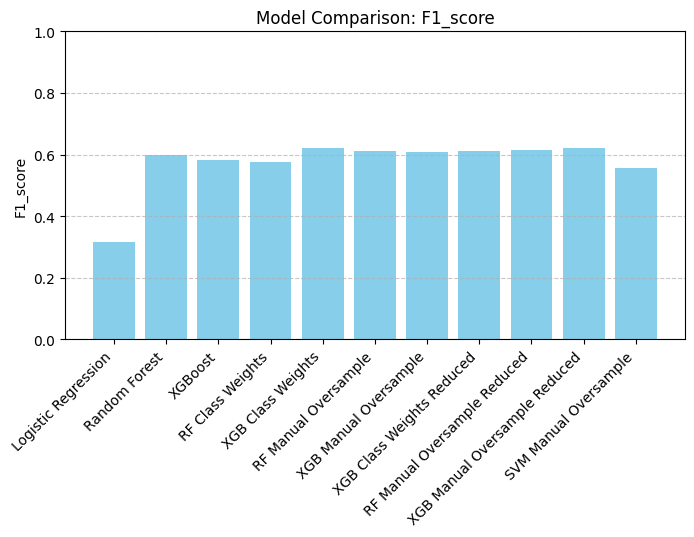

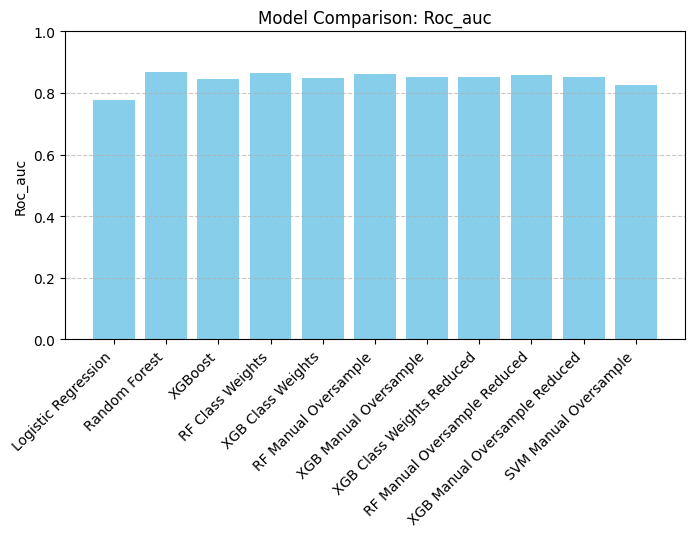

In [37]:

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

for metric in metrics_to_plot:
    plt.figure(figsize=(8,4))
    plt.bar(results_df['Model'], results_df[metric], color='skyblue')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1)
    plt.title(f'Model Comparison: {metric.capitalize()}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# Hyperparameter Tuning

### XGB oversampled 

Fitting 3 folds for each of 20 candidates, totalling 60 fits


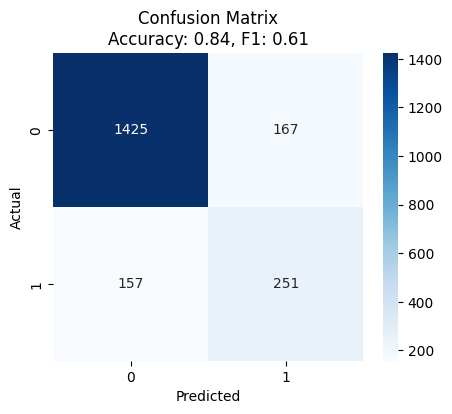

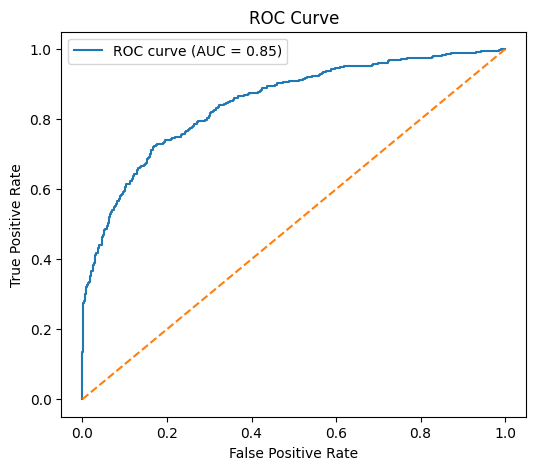

,Metric,Score
0,Accuracy,0.8380
1,Precision,0.6005
2,Recall,0.6152
3,F1 Score,0.6077
4,ROC AUC,0.8475


In [38]:
from sklearn.model_selection import RandomizedSearchCV

# Param grid for XGBoost
xgb_param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

xgb_manual_over_tune = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=42
)

xgb_search = RandomizedSearchCV(
    xgb_manual_over_tune,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train_over_reduced, y_train_over)
best_xgb_manual_over = xgb_search.best_estimator_

metrics_xgb_manual_over_tuned = train_evaluate_model(
    best_xgb_manual_over,
    X_train_over_reduced,
    y_train_over,
    X_test_reduced,
    y_test
)


### RF class weights

Fitting 3 folds for each of 20 candidates, totalling 60 fits


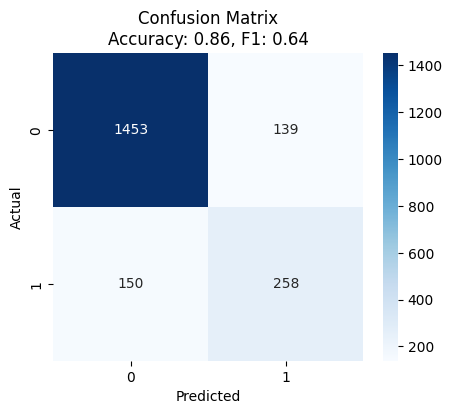

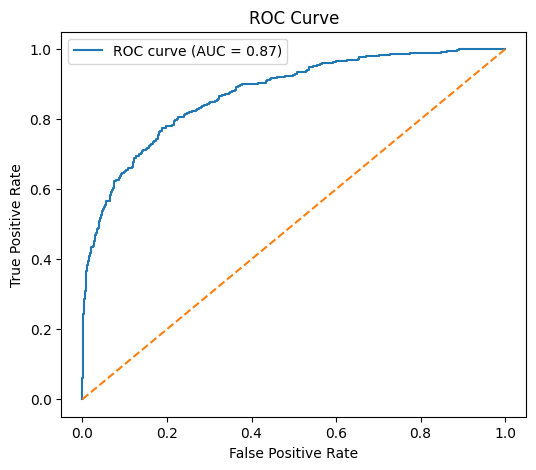

,Metric,Score
0,Accuracy,0.8555
1,Precision,0.6499
2,Recall,0.6324
3,F1 Score,0.6410
4,ROC AUC,0.8734


In [39]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_class_weight_tune = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)

rf_search = RandomizedSearchCV(
    rf_class_weight_tune,
    param_distributions=rf_param_grid,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train_reduced, y_train)
best_rf_class_weight = rf_search.best_estimator_

metrics_rf_class_weight_tuned = train_evaluate_model(
    best_rf_class_weight,
    X_train_reduced,
    y_train,
    X_test_reduced,
    y_test
)


### XGB class weights

Fitting 3 folds for each of 20 candidates, totalling 60 fits


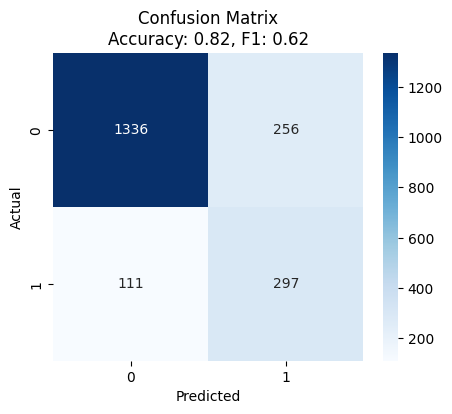

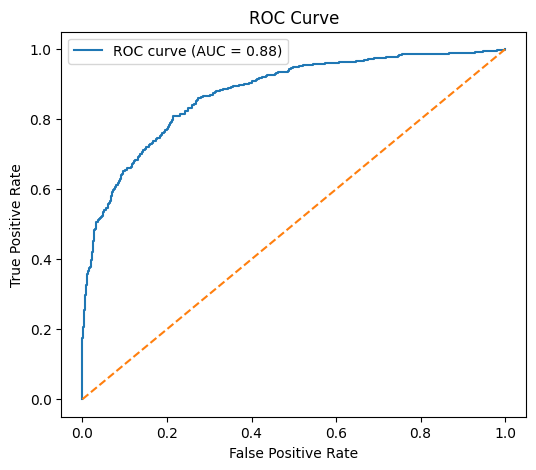

,Metric,Score
0,Accuracy,0.8165
1,Precision,0.5371
2,Recall,0.7279
3,F1 Score,0.6181
4,ROC AUC,0.8751


In [40]:
# reuse xgb_param_grid from part 1

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_class_weight_tune = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

xgb_cw_search = RandomizedSearchCV(
    xgb_class_weight_tune,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

xgb_cw_search.fit(X_train_reduced, y_train)
best_xgb_class_weight = xgb_cw_search.best_estimator_

metrics_xgb_class_weight_tuned = train_evaluate_model(
    best_xgb_class_weight,
    X_train_reduced,
    y_train,
    X_test_reduced,
    y_test
)


### SVm Oversampled

In [41]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# # Parameter grid
# svm_param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']  # only applies for rbf
# }

# # SVM with probability=True for ROC AUC
# svm_base = SVC(probability=True, random_state=42)

# # Grid search
# svm_grid = GridSearchCV(svm_base, svm_param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)

# # Fit
# svm_grid.fit(X_train_over, y_train_over)

# print(f"Best params: {svm_grid.best_params_}")

# # Evaluate best model
# metrics_svm_over_tuned = train_evaluate_model(svm_grid.best_estimator_, X_train_over, y_train_over, X_test, y_test)

# print("SVM with Manual Oversampling Tuned Metrics:", metrics_svm_over_tuned)


## Results after Tuning

In [42]:
results_tuning = {
    'XGB Manual Oversample Reduced': metrics_xgb_manual_over,
    'XGB Manual Oversample Reduced Tuned': metrics_xgb_manual_over_tuned,
    'RF Class Weights': metrics_rf_wt,
    'RF Class Weights Tuned': metrics_rf_class_weight_tuned,
    'XGB Class Weights': metrics_xgb_wt,
    'XGB Class Weights Tuned': metrics_xgb_class_weight_tuned,
    'SVM Manual Oversample': metrics_svm_over#,
    #'SVM Manual Oversample Tuned': metrics_svm_over_tuned
}

# You can print nicely or plot
results_df = pd.DataFrame(results_tuning).T
# print(results_df)


In [43]:
results_df

,accuracy,precision,recall,f1_score,roc_auc
XGB Manual Oversample Reduced,0.8360,0.586957,0.661765,0.622120,0.850992
XGB Manual Oversample Reduced Tuned,0.8380,0.600478,0.615196,0.607748,0.847453
RF Class Weights,0.8675,0.826484,0.443627,0.577352,0.863665
RF Class Weights Tuned,0.8555,0.649874,0.632353,0.640994,0.873440
XGB Class Weights,0.8370,0.591111,0.651961,0.620047,0.847707
XGB Class Weights Tuned,0.8165,0.537071,0.727941,0.618106,0.875066
SVM Manual Oversample,0.7590,0.445588,0.742647,0.556985,0.825987


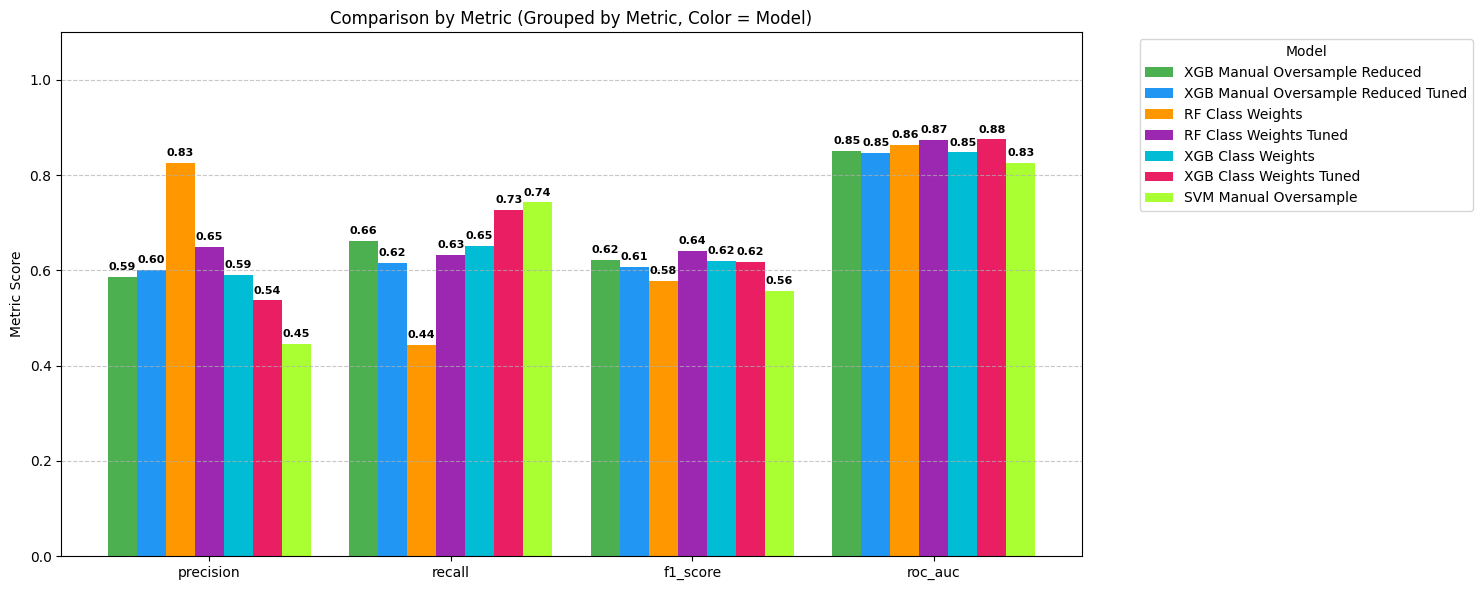

In [44]:


# Data
plot_df = results_df[['precision', 'recall', 'f1_score', 'roc_auc']]
metrics = plot_df.columns.tolist()
models = plot_df.index.tolist()

x = np.arange(len(metrics))  # group positions (Precision, Recall, etc.)
width = 0.12  # narrower bars to fit all models

# Assign consistent colors for each model
model_colors = {
    'XGB Manual Oversample Reduced': '#4caf50',
    'XGB Manual Oversample Reduced Tuned': '#2196f3',
    'RF Class Weights': '#ff9800',
    'RF Class Weights Tuned': '#9c27b0',
    'XGB Class Weights': '#00bcd4',
    'XGB Class Weights Tuned': '#e91e63',
    'SVM Manual Oversample': '#AAFF32'#,
    #'SVM Manual Oversample Tuned': '#C79FEF'
}

fig, ax = plt.subplots(figsize=(15,6))

for i, (model, color) in enumerate(model_colors.items()):
    offsets = x + (i - (len(model_colors)-1)/2) * width
    bars = ax.bar(offsets, plot_df.loc[model], width, label=model, color=color)
    
    # Add data labels
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.01, 
            f"{height:.2f}", 
            ha='center', va='bottom', fontsize=8, fontweight='bold'
        )

# Final touches
ax.set_ylabel('Metric Score')
ax.set_title('Comparison by Metric (Grouped by Metric, Color = Model)')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=0, ha='center')
ax.set_ylim(0, 1.1)
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Conclusion

In this project, we aimed to predict customer churn using a bank dataset with multiple modeling strategies, addressing class imbalance through manual oversampling and class weighting. After comparing various models and tuning efforts, we found that:

* XGBoost with class weights and tuning provided the best recall (0.73) and the highest ROC AUC (0.875), making it suitable when the business goal is to identify as many potential churners as possible, even at the cost of some false positives.

* Random Forest with class weights and tuning delivered the best F1 score (0.641), striking a better balance between precision and recall — suitable when false positives need to be minimized alongside detecting churners.

* SVM models underperformed compared to tree-based methods in this scenario, both before and after tuning. Even with higher recall, the precision is very low.

🌟 Highlights

Best model (for high recall) → XGBoost Class Weights Tuned: Recall 0.73, ROC AUC 0.875

Best model (for balanced precision/recall) → RF Class Weights Tuned: F1 Score 0.641, ROC AUC 0.873

We effectively handled class imbalance and compared multiple approaches for robust model selection.

The models are ready for deployment after saving and documenting the preprocessor and trained model.

In [45]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['Geography', 'Gender', 'Card Type']),
                                ('scaler', StandardScaler(),
                                 ['CreditScore', 'Age', 'Balance',
                                  'EstimatedSalary', 'Point Earned'])])

In [46]:
best_xgb_class_weight

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

# Safe FeatureSelector
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features, feature_names=None):
        self.selected_features = selected_features
        self.feature_names = feature_names  # Needed if input is array
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # If X is DataFrame, use selected_features
        if isinstance(X, pd.DataFrame):
            return X[self.selected_features]
        # If X is array, assume feature_names provided
        elif self.feature_names is not None:
            df = pd.DataFrame(X, columns=self.feature_names)
            return df[self.selected_features].values
        else:
            raise ValueError("Feature names must be provided when input is array")

# Create selector
selector = FeatureSelector(selected_features=selected_features, feature_names=final_feature_names)

# Final pipeline — no FunctionTransformer, all standard components
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', best_xgb_class_weight)
])


In [48]:
selected_features

['Geography_Germany',
 'Gender_Male',
 'CreditScore',
 'Age',
 'Balance',
 'EstimatedSalary',
 'Point Earned',
 'HasCrCard',
 'IsActiveMember',
 'NumOfProducts',
 'Satisfaction Score']

In [49]:
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Geography', 'Gender',
                                                   'Card Type']),
                                                 ('scaler', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Balance', 'EstimatedSalary',
                                                   'Point Earned'])])),
                ('selector',
                 FeatureSelector(feature_names=['Geography_Germany',
                                                'Geography_Spain',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [50]:
import joblib

# Save to file
joblib.dump(final_pipeline, 'churn_model_pipeline.pkl')

print("Pipeline saved as churn_model_pipeline.pkl")


Pipeline saved as churn_model_pipeline.pkl


In [51]:
loaded_pipeline = joblib.load('churn_model_pipeline.pkl')
sample_df = df_v2.sample(20, random_state=24).copy()
# sample_df = df_v2[df_v2.Exited == 1].sample(20, random_state=24).copy()

X_sample = sample_df.drop(columns=['Exited'])
y_sample = sample_df['Exited']  # Actual labels to compare later


In [52]:
# Predict churn (0/1) for sample data
y_pred = loaded_pipeline.predict(X_sample)

# (Optional) predict probabilities
y_proba = loaded_pipeline.predict_proba(X_sample)[:,1]


      Exited  Predicted_Exited  Prediction_Prob
6252       0                 0         0.109944
4684       0                 0         0.092707
1731       0                 0         0.237202
4742       0                 0         0.309677
4521       0                 0         0.154862


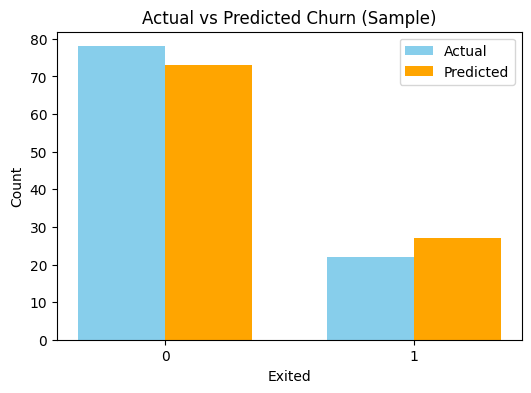

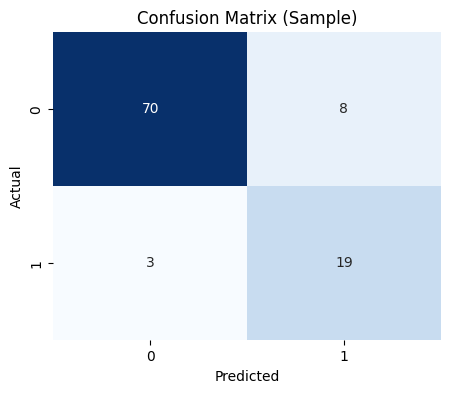

Classification Report (Sample):
              precision    recall  f1-score   support

           0     0.9589    0.8974    0.9272        78
           1     0.7037    0.8636    0.7755        22

    accuracy                         0.8900       100
   macro avg     0.8313    0.8805    0.8513       100
weighted avg     0.9028    0.8900    0.8938       100



In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Your sample and prediction part
sample_df = raw_df.sample(100, random_state=42).copy()
X_sample = sample_df.drop(columns=['Exited'])
y_sample = sample_df['Exited']

y_pred = loaded_pipeline.predict(X_sample)
y_proba = loaded_pipeline.predict_proba(X_sample)[:,1]

comparison_df = sample_df[['Exited']].copy()
comparison_df['Predicted_Exited'] = y_pred
comparison_df['Prediction_Prob'] = y_proba

print(comparison_df.head())

# 1️⃣ Grouped bar plot: count of each class for actual & predicted
actual_counts = comparison_df['Exited'].value_counts().sort_index()
pred_counts = comparison_df['Predicted_Exited'].value_counts().sort_index()

labels = [0, 1]
x = range(len(labels))

plt.figure(figsize=(6,4))
width = 0.35

plt.bar([i - width/2 for i in x], actual_counts, width=width, label='Actual', color='skyblue')
plt.bar([i + width/2 for i in x], pred_counts, width=width, label='Predicted', color='orange')

plt.xticks(x, labels)
plt.xlabel('Exited')
plt.ylabel('Count')
plt.title('Actual vs Predicted Churn (Sample)')
plt.legend()
plt.show()

# 2️⃣ Confusion matrix
cm = confusion_matrix(y_sample, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Sample)")
plt.show()

# 3️⃣ Classification report
print("Classification Report (Sample):")
print(classification_report(y_sample, y_pred, digits=4))


## Model Summary and Usage

This churn prediction model uses an **XGBoost classifier** tuned with class weights to handle class imbalance. It requires **preprocessed input features** where:

- **Categorical features** (Geography, Gender, Card Type) are one-hot encoded.
- **Numerical features** (CreditScore, Age, Balance, EstimatedSalary, Point Earned) are scaled.
- **Binary and discrete features** (HasCrCard, IsActiveMember, Tenure, NumOfProducts, Satisfaction Score) are passed as is.
- A feature selection step reduces input to the most important features.

### Key points:

- The model **expects input data to be preprocessed with the exact same pipeline** used in training.
- Output includes both the predicted churn class (`Exited`) and churn probability.
- Correct input columns and data types are mandatory for valid predictions.

This ensures consistent, reliable performance on new data.
